# Micrograd: Tutorial on automatic differentiation using backpropagation
## by Andrej Karpathy

This notebook just contains the code that he copy-pastes and that is too long to type along, along with a time stamp referring to [the video](https://www.youtube.com/watch?v=VMj-3S1tku0).
You will need to change this code later, so it is easiest to follow along by just adding to this notebook.

# Preliminary exploration

## Required modules

Dependencies for math operations and plotting

In [94]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Functions of a single variable

In [95]:
def f(x):
    return 3.0*x**2 - 4.0*x + 5.0

In [96]:
f(3.0)

20.0

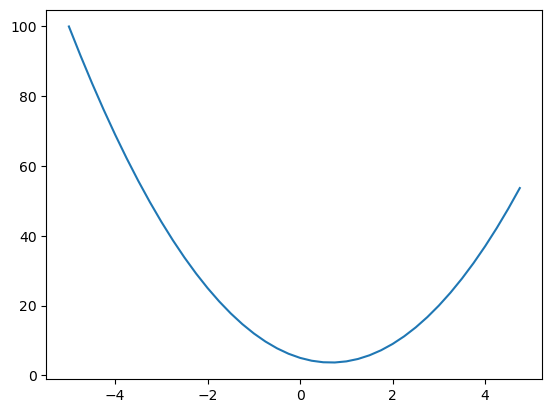

In [97]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

### Numerical derivative

In [98]:
h = 0.001
x = 3.0
(f(x + h) - f(x))/h  # fill in

14.00300000000243

## Functions of multiple variables

In [101]:
# Let's get more complex

# Inputs
a = 2.0
b = -3.0
c = 10.0

# Function
d = lambda a,b,c: a*b + c
print(d(a, b, c))

4.0


### Numerical derivative

Similar implementation to the video, but using a function to define `d` to make it a bit cleaner.

In [105]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0


# Function with variations

# Variation in a
d1 = d(a, b, c)
d2 = d(a+h, b, c)
print('Variation in a:')
print('   d1', d1)
print('   d2', d2)
print('   slope', (d2 - d1)/h)  # the derivative

# Variation in b
d1 = d(a, b, c)
d2 = d(a, b+h, c)
print('\nVariation in b:')
print('   d1', d1)
print('   d2', d2)
print('   slope', (d2 - d1)/h)  # the derivative

# Variation in c
d1 = d(a, b, c)
d2 = d(a, b, c+h)
print('\nVariation in c:')
print('   d1', d1)
print('   d2', d2)
print('   slope', (d2 - d1)/h)  # the derivative

Variation in a:
   d1 4.0
   d2 3.999699999999999
   slope -3.000000000010772

Variation in b:
   d1 4.0
   d2 4.0002
   slope 2.0000000000042206

Variation in c:
   d1 4.0
   d2 4.0001
   slope 0.9999999999976694


# Micrograd

## Value class

In [122]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
#         self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        # Print a nice output
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # Addition operator
        out = Value(self.data + other.data, (self, other), '+')
        
#         # Define the local derivate backwards propagation
#         def _backward():
#             self.grad += 1.0 * out.grad
#             other.grad += 1.0 * out.grad    
#         out._backward = _backward
        
        return out
        
    def __mul__(self, other):
        # Multiplication operator
        out = Value(self.data * other.data, (self, other), '*')
        
#         # Define the local derivate backwards propagation
#         def _backward():
#             self.grad += other.data * out.grad 
#             other.grad += self.data * out.grad    
#         out._backward = _backward
        
        return out
    
#     def tanh(self):
#         # Hyperbolic tangent function
#         x = self.data
#         t = (math.exp(2.0*x) - 1.0)/(math.exp(2.0*x) + 1)
#         out = Value(t, (self, ), 'tanh')
        
#         # Define the local derivate backwards propagation
#         def _backward():
#             self.grad += (1 - t**2) * out.grad 
#         out._backward = _backward
        
#         return out
    
#     def backward(self):
#         # Topological sorting
#         topo = []
#         visited = set()
#         def build_topo(v):
#             if v not in visited:
#                 visited.add(v)
#                 for child in v._prev:
#                     build_topo(child)
#                 topo.append(v)
#         build_topo(self)
        
#         # Go over the sorted noded and compute backwards propagation in reverse order
#         self.grad = 1.0
#         for node in reversed(topo):
#             node._backward()
    
    

In [123]:
# Define three values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print('The values a, b,c:')
print(a)
print(b)
print(c)

# Do some operations with them and print the result
e = a*b; e.label = 'e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f

print('\nThe value of d:')
print(d)
print('\nThe value of L:')
print(L)

The values a, b,c:
Value(data=2.0)
Value(data=-3.0)
Value(data=10.0)

The value of d:
Value(data=4.0)

The value of L:
Value(data=-8.0)


## Visualization code (at time 25:07)

Copy pasted code so with visualization functions

In [124]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad: %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
            
    return dot

You can now visualize the ``Value`` objects

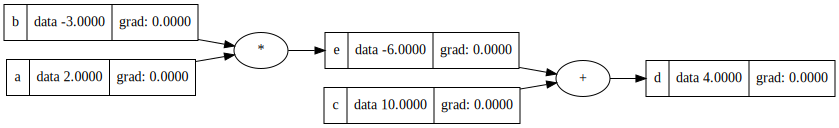

In [125]:
draw_dot(d)

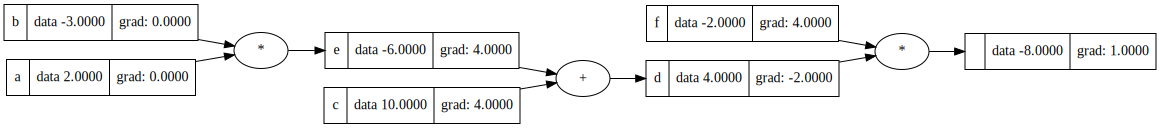

In [143]:
draw_dot(L)

Back propagation by hand

One important point to have in mind here is:

$$
L(f, d) = f\cdot d
$$

with $d = d(c, e)$ or with $e = e(a, b)$ therefore $d = d(c, e(a, b))$. If we expand the derivative we have:

$$
\frac{\partial L}{\partial f} = \frac{\partial (f\cdot d)}{\partial f} = \frac{\partial f}{\partial f} d + \frac{\partial d}{\partial f} f = d + 0 = d.
$$

and 

$$
\frac{\partial L}{\partial d} = \frac{\partial (f\cdot d)}{\partial d} = \frac{\partial f}{\partial d} d + \frac{\partial d}{\partial d} f = 0 + f = f.
$$

Note that, if $d = f + c$ instead of $d = e + c$ then we would have:
$$
\frac{\partial L}{\partial f} = \frac{\partial (f\cdot d)}{\partial f} = \frac{\partial f}{\partial f} d + \frac{\partial d}{\partial f} f = \frac{\partial f}{\partial f} d + \frac{\partial (f + c)}{\partial f} f = d + f.
$$

Another important point to have in mind, regarding notation, is the following. although it is written `d.grad`, in fact this means the derivative of `L` with respect to `d` and not the gradient of `d`. In more general terms, `d.grad` is the derivative of the root expression (highest level) with respect to the variable we are considering.

In [144]:
# L = d * f
# d = e + c
# e = b * a

# So for the different layers (levels) of the expression we have:
# L = d * f            (first level)
# L = (e + c) * f      (second level)
# L = ((b*a) + c) * f  (third level)
L.grad = 1.0 # initialize it to it value, since dL/dL = 1
d.grad = f.data  #  L = d*f => dL/dd = f
f.grad = d.data  #  L = d*f => dL/df = d

So now to compute $\frac{\partial L}{\partial c}$ we need to use the chain rule to get:

$$
\frac{\partial L}{\partial c} = \frac{\partial L(d, f)}{\partial c} = \frac{\partial L(d, f)}{\partial d}\frac{\partial d}{\partial c} + \frac{\partial L(d, f)}{\partial f}\frac{\partial f}{\partial c} = \frac{\partial L(d, f)}{\partial d}\frac{\partial (e + c)}{\partial c} + 0 = \frac{\partial L(d, f)}{\partial d}\cdot 1 = \frac{\partial L(d, f)}{\partial d}.
$$

We can see that we reused $\frac{\partial L(d, f)}{\partial d}$ and $\frac{\partial L(d, f)}{\partial f}$ that was computed in the previous step.

This expression clearly shows that at each point of the graph we just need to have the derivative of the upstream expression with respect to the parent and the derivative of the parent with respect to the child. Combining the two we can easily get the derivative of the root expression with respect to the node.

In [142]:
c.grad = f.data * d.grad  # this is just the expression from the chain rule
e.grad = f.data * d.grad  # this is just the expression from the chain rule

In [141]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label ='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0 + h, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    d.data = d.data
    f = Value(-2.0, label='f')
    L = d*f; L.label ='L'
    
    L2 = L.data
    
    print('Derivative:', (L2 - L1)/h)
    
lol()
    
    

Derivative: -1.9999999999953388
